In [1]:
import numpy as np
from pyicecube10.analysis import AnalyzeCircle, energybins
from matplotlib import pyplot as plt
from gammapy.stats import wstat
from scipy.interpolate import interp1d
%matplotlib inline

In [2]:
def powerlaw(A, gamma):
    return A * 1e-17 * 1e-3 * (energybins['Enu'] / 1e5)**(-gamma)

In [3]:
def e2ulim(ra, dec,r, b):
    anal = AnalyzeCircle(ra, dec, r, b, years=('40', '59', '79', '86_I', '86_II', '86_III', '86_IV', '86_V', '86_VI', '86_VII'))

    tpb = anal.total_per_bin()
    bpb = anal.background_per_bin()
    alpha_back = anal.alpha_back

    def log_like(norm, gamma):
        return - 0.5 * sum(wstat(tpb, bpb / alpha_back, alpha_back, anal.expected_counts(powerlaw, norm, gamma)))

    level = 0.9

    #gammas = np.linspace(0, 4.5, 100)
    norms = np.linspace(-10, 30, 400)

    gammas = [2.]
    ulims = []
    for gamma in gammas:
        like = []
        for norm in norms:
            like.append(log_like(norm, gamma))
        like = np.e ** np.array(like)
        lkl_fl = sorted(like, reverse = True)
        cum_lkl = np.cumsum(lkl_fl) / np.sum(lkl_fl)
        #f = interp1d(cum_lkl, lkl_fl)
        #val = float(f(level))
        ind = np.searchsorted(cum_lkl, level)
        val = lkl_fl[ind]
        ind_ul = np.where(like>=val)[0][-1]
        ulims.append(norms[ind_ul])
    anal._clear_caches()    
    return ulims[0]#, norms, like

In [6]:
ras = 360 * np.random.random(5)
decs = [-10, 0, 10, 20, 30, 50, 60]
radii = np.linspace(0.3, 2.7, 25)
betas = np.linspace(0.5, 2.3, 10)


In [ ]:


results = []
for dec in decs:
    byra = np.zeros((len(betas), len(radii)))
    for ra in ras:
        this_ra = []
        for b in betas:
            this_ra.append([])
            for r in radii:
                this_ra[-1].append(e2ulim(ra, dec, r, b))
        byra += np.array(this_ra)
    results.append( byra / len(ras) )

In [10]:
import pickle
with open('results2.pkl', 'wb') as fd:
    pickle.dump(results, fd)

In [14]:
np.array(results).shape

(7, 10, 25)

In [7]:
import pickle
limits = np.zeros((7,10,25))
for fn in range(3):
    with open(f'results{fn}.pkl', 'rb') as fd:
        res = pickle.load(fd)
        limits += np.array(res)
limits /= 3

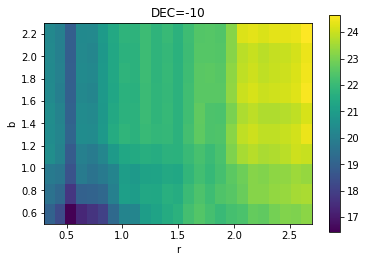

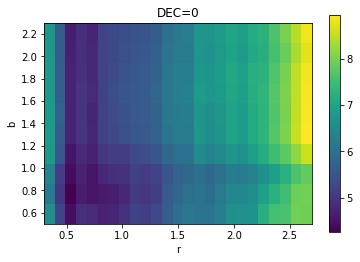

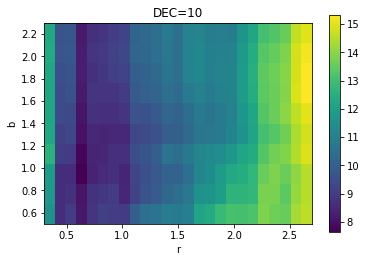

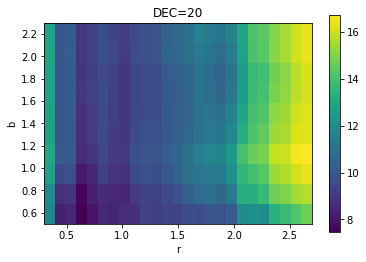

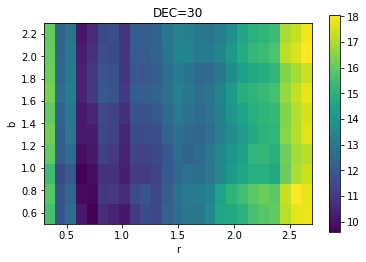

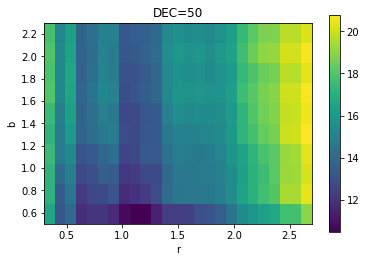

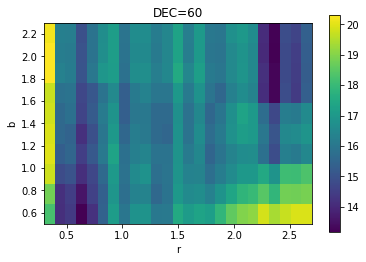

In [8]:
for i, dec in enumerate(decs):
    plt.figure()
    plt.imshow(limits[i].astype('float'), origin='lower', extent = (0.3, 2.7, 0.5,  2.3))
    plt.xlabel('r')
    plt.ylabel('b')
    plt.colorbar()
    plt.title(f'DEC={dec}')

In [29]:
mins = []
for i, dec in enumerate(decs):
    mins.append(limits[i].min())
    min_ind = np.unravel_index(limits[i].argmin(), shape=limits[i].shape)
    print(betas[min_ind[0]], radii[min_ind[1]])

0.5 0.5
0.7 0.5
0.8999999999999999 0.6000000000000001
0.5 0.6000000000000001
0.5 0.7000000000000001
0.5 1.2000000000000002
0.5 0.6000000000000001


In [20]:
sens = np.loadtxt('sensitivityE2.csv', delimiter=',')
five_sig = np.loadtxt('five_sig_E2.csv', delimiter=',')

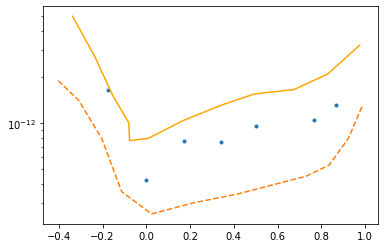

In [30]:
plt.plot(np.sin(np.deg2rad(decs)), np.array(mins) * 1e-13, '.')
plt.plot(sens[:,0], sens[:,1], '--')
plt.plot(five_sig[:,0], five_sig[:,1], c='orange')
plt.yscale('log')